In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings("ignore")

# Load dataset directly from GitHub

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

#  Binary to Numarical conversion 

In [3]:
bin_cols = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
for col in bin_cols: df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0})
special_cols = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in special_cols: df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})
df = pd.get_dummies(df, drop_first=True)

# Encode binary categorical columns

In [ ]:
X, y = df.drop('Churn', axis=1), df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree with GridSearch

In [5]:
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), {
    'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]
}, cv=cv, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)
dt_preds = dt_grid.best_estimator_.predict(X_test)

# Random Forest with GridSearch

In [6]:
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), {
    'n_estimators': [50, 100, 150], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]
}, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_preds = rf_grid.best_estimator_.predict(X_test)

# Metrics function

In [7]:
def print_metrics(name, y_true, y_pred):
    print(f"\n{name} Metrics:\nAccuracy: {accuracy_score(y_true, y_pred):.4f} | Precision: {precision_score(y_true, y_pred):.4f} | Recall: {recall_score(y_true, y_pred):.4f} | F1: {f1_score(y_true, y_pred):.4f}")
    print("Report:\n", classification_report(y_true, y_pred))

In [8]:
print("Best Decision Tree:", dt_grid.best_params_)
print("Best Random Forest:", rf_grid.best_params_)
print_metrics("Decision Tree", y_test, dt_preds)
print_metrics("Random Forest", y_test, rf_preds)

Best Decision Tree: {'max_depth': 5, 'min_samples_split': 10}
Best Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Decision Tree Metrics:
Accuracy: 0.7730 | Precision: 0.5737 | Recall: 0.5686 | F1: 0.5712
Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1549
           1       0.57      0.57      0.57       561

    accuracy                           0.77      2110
   macro avg       0.71      0.71      0.71      2110
weighted avg       0.77      0.77      0.77      2110


Random Forest Metrics:
Accuracy: 0.7910 | Precision: 0.6463 | Recall: 0.4724 | F1: 0.5458
Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.86      1549
           1       0.65      0.47      0.55       561

    accuracy                           0.79      2110
   macro avg       0.74      0.69      0.71      2110
weighted avg       0.78      0.79      0.78      2110



# Visualize Confusion Matrices

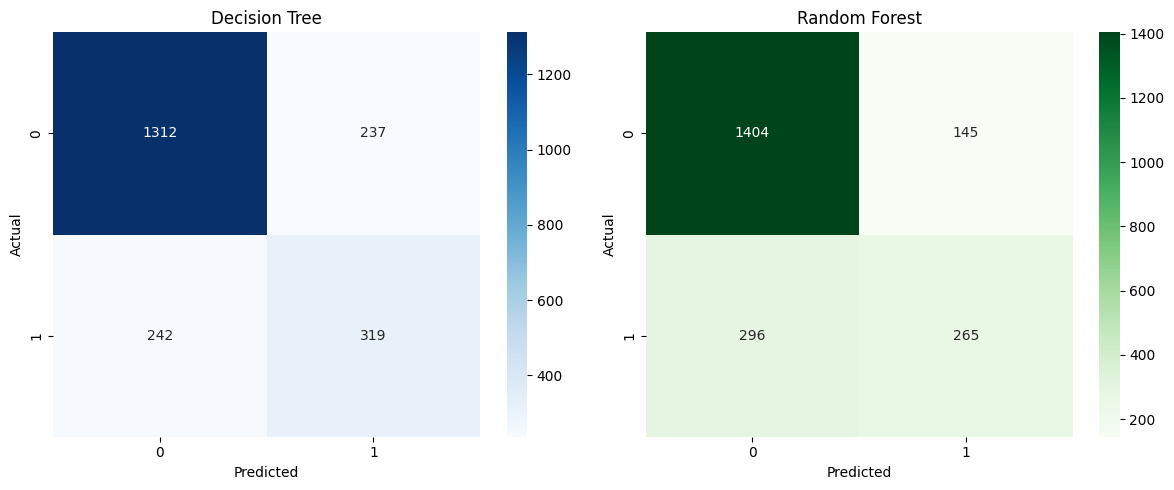

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, dt_preds), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Decision Tree'), ax[0].set_xlabel("Predicted"), ax[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Random Forest'), ax[1].set_xlabel("Predicted"), ax[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()